Team Members: Anurag Marwah (Net ID: am8482)

# Initialize

In [1]:
import keras

/Applications/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from scipy import misc
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import decode_predictions, preprocess_input

# Download Model

In [4]:
start_time = time.time()
# Download pre-trained convolutional neural net
model = VGG16(weights='imagenet')
elapsed_time = time.time() - start_time
print('Time to download: {0:.2f} seconds'.format(elapsed_time))

Time to download: 3.49 seconds


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
model.input_shape

(None, 224, 224, 3)

# Load Test Data

In [7]:
batch_size = 10
nrow = model.input_shape[1]
ncol = model.input_shape[2]
nchan = model.input_shape[3]
image_parts = 9
new_batch_shape = (image_parts,nrow,ncol,nchan)

## Load Test Images

In [8]:
batch_size = 10
class_name = 'testimage'
batch_shape1 = (batch_size,nrow,ncol,nchan)
batch_shape2 = (batch_size,2*nrow,2*ncol,nchan)
batch_shape3 = (batch_size,2*nrow,ncol,nchan)
batch_shape4 = (batch_size,nrow,2*ncol,nchan)
x = np.zeros(batch_shape1)
x2 = np.zeros(batch_shape2)
x3 = np.zeros(batch_shape3)
x4 = np.zeros(batch_shape4)
for i in range(batch_size):    
    fn = '{0:s}/{1:s}_{2:1d}.jpg'.format(class_name,class_name, i)  
    x[i,:,:,:] = image.load_img(fn, target_size=(nrow, ncol))
    x2[i,:,:,:] = image.load_img(fn, target_size=(2*nrow, 2*ncol))
    x3[i,:,:,:] = image.load_img(fn, target_size=(2*nrow, ncol))
    x4[i,:,:,:] = image.load_img(fn, target_size=(nrow, 2*ncol))

## Display Test Images

In [9]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

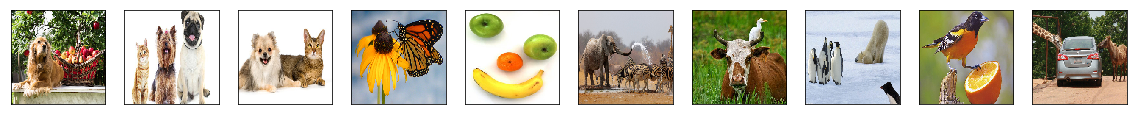

In [10]:
plt.figure(figsize=(20,20))
nplot = 10
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(x[i,:,:,:])

# Process the Test Data and Classify

## Break Image into Parts

In [11]:
def breakimage(x,x2,x3,x4):
    t = np.zeros(new_batch_shape)
    t[0,:,:,:] = x[:,:,:]
    t[1,:,:,:] = x2[0:224,0:224,:] # Both-split 1
    t[2,:,:,:] = x2[0:224,224:448,:] # Both-split 2
    t[3,:,:,:] = x2[224:448,0:224,:] # Both-split 3
    t[4,:,:,:] = x2[224:448,224:448,:] # Both-split 4
    t[5,:,:,:] = x3[0:224,:,:] # Hori-split 1
    t[6,:,:,:] = x3[224:448,:,:] # Hori-split 2
    t[7,:,:,:] = x4[:,0:224,:] # Vert-split 1
    t[8,:,:,:] = x4[:,224:448,:] # Vert-split 2
    plt.figure(figsize=(20,20))
    
    # Display sub-images
    nplot = 9
    for i in range(nplot):    
        plt.subplot(1,nplot,i+1)
        disp_image(t[i,:,:,:])
    
    return t

## Classify Test Images

In [12]:
def classifyimage(t):
    t2 = preprocess_input(t)
    preds = model.predict(t2)
    preds_decoded = decode_predictions(preds, top=3)
    ntop = 3
    res_dict = {}
    for i in range(ntop):
        class_name = []
        class_prob = []
        for j in range(9):
            class_name.append(preds_decoded[j][i][1])
            class_prob.append(preds_decoded[j][i][2])

        name_col = str('class %d' % i)
        prob_col = str('prob %d' % i)
        res_dict[name_col] = class_name
        res_dict[prob_col] = class_prob
    return res_dict

In [13]:
def multiclassimages(x,x2,x3,x4,i):
    t2 = np.zeros(new_batch_shape)
    t2 = breakimage(x[i,:,:,:],x2[i,:,:,:],x3[i,:,:,:],x4[i,:,:,:])
    df = pd.DataFrame(data=classifyimage(t2))
    print(df)

            class 0           class 1         class 2    prob 0    prob 1  \
0    cocker_spaniel  golden_retriever    Afghan_hound  0.766667  0.057201   
1    cocker_spaniel  golden_retriever  Sussex_spaniel  0.977880  0.007292   
2               hip       pomegranate             fig  0.801726  0.104667   
3  golden_retriever      Afghan_hound  cocker_spaniel  0.353880  0.171139   
4   shopping_basket            hamper   shopping_cart  0.416912  0.186214   
5              cock      picket_fence             hen  0.225569  0.205054   
6      butcher_shop              cock            mask  0.052486  0.047130   
7  golden_retriever    cocker_spaniel    Irish_setter  0.536958  0.401182   
8       pomegranate   shopping_basket          orange  0.359964  0.276533   

     prob 2  
0  0.044101  
1  0.004758  
2  0.021298  
3  0.165409  
4  0.050461  
5  0.139648  
6  0.037781  
7  0.009304  
8  0.040549  
              class 0             class 1          class 2    prob 0  \
0              br

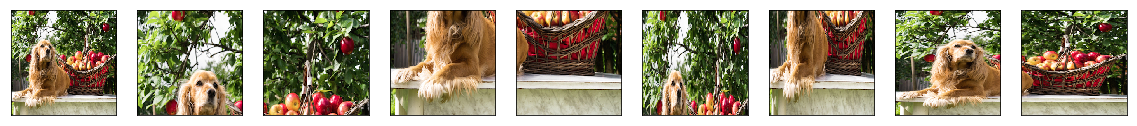

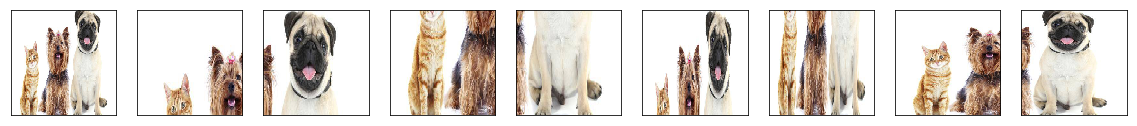

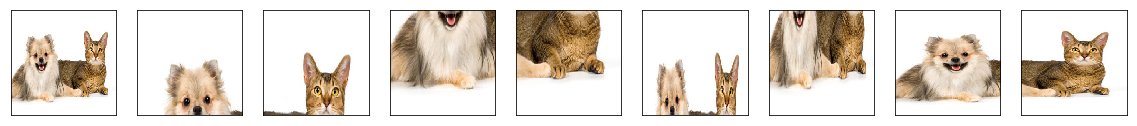

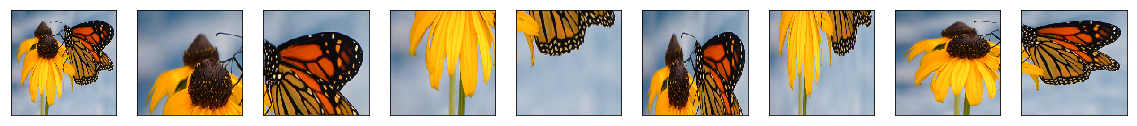

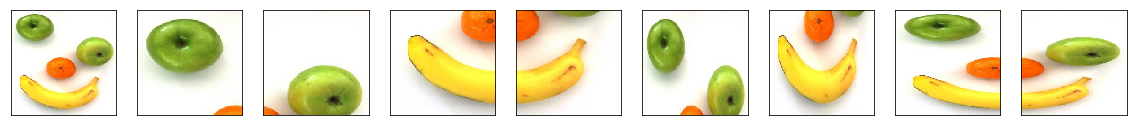

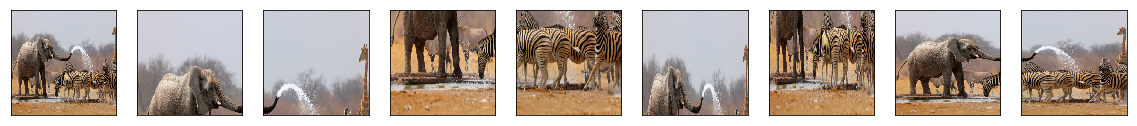

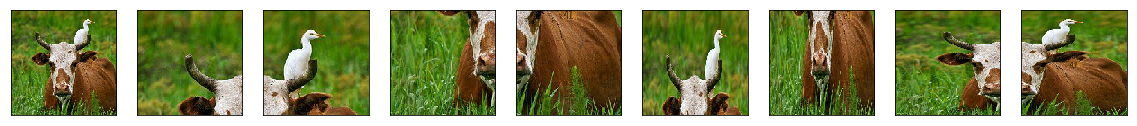

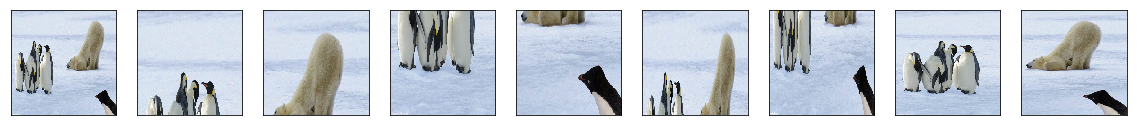

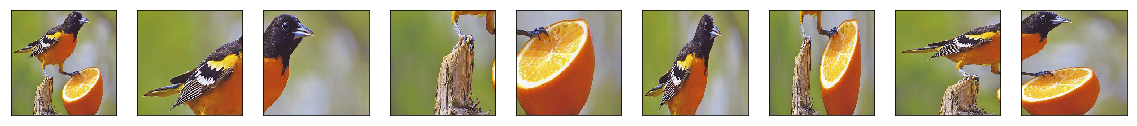

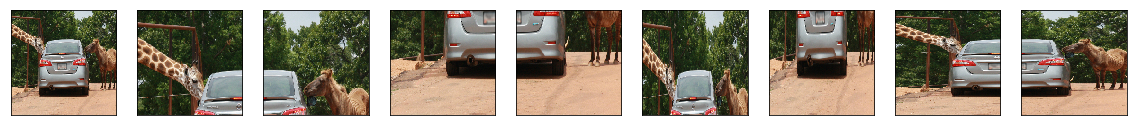

In [14]:
start_time = time.time()
for i in range(batch_size): 
    multiclassimages(x,x2,x3,x4,i)
elapsed_time = time.time() - start_time
print('Total Run-Time: {0:.2f} seconds'.format(elapsed_time))